# Assignment B
---

1) Downloaded 50 images of dogs which can be found [here](https://github.com/genigarus/EVA4/tree/master/S12/AssignmentB/dogs). 

2) Annotated bounding boxes around the dogs using VIA.

3) JSON file containing the annotations can be found [here](https://github.com/genigarus/EVA4/blob/master/S12/AssignmentB/dog_annotations.json). 

4) Described the contents of this annoation JSON file in FULL details [here](). 


## 5) Finding out the best total numbers of clusters for this dog dataset.

In [1]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.19-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

### Imports
---

In [3]:
import os
import json
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
default_path = 'drive/EVA4/Session12/AssignmentB/'
data_json_file = "dog_annotations.json"

### Helper Functions
---

In [0]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes_with_labels, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    #return np.mean([iou(boxes_with_labels['bbox'][i], clusters[boxes_with_labels['cluster_centroid'][i]]) for i in range(boxes_with_labels['bbox'].shape[0])])
    return np.mean([np.max(iou(boxes_with_labels['bbox'][i], clusters)) for i in range(boxes_with_labels['bbox'].shape[0])])

def kmeans_clustering(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

def iterate_kmeans(num_iter, X, bbox_X, is_sklearn=True):
  # find optimal no. of K
  wcss = []
  if is_sklearn:
    for i in range(1,num_iter):
      kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
      kmeans.fit(X)
      clusters = kmeans.cluster_centers_
      boxes_with_labels = {'bbox': bbox_X, 'cluster_centroid': kmeans.labels_}
      wcss.append(avg_iou(boxes_with_labels, clusters))
  else:
    for i in range(1,num_iter):
      clusters = kmeans_clustering(X, i)
      boxes_with_labels = {'bbox': bbox_X}
      wcss.append(avg_iou(boxes_with_labels, clusters))
  
  return wcss

def visualize(xs, ys):
  plt.figure(figsize=(20,10))
  # 'bo-' means blue color, round points, solid lines
  plt.plot(xs, ys,'bo-')
  plt.xlabel("Number of Clusters")
  plt.ylabel("Mean IoU")
  plt.title("Mean IoU vs Number of Clusters")
  
  # zip joins x and y coordinates in pairs
  for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
  plt.show()

def create_clusters(X, n_clusters, init='k-means++', n_init=10, random_state=0, is_sklearn=True):
  # create clusters
  if is_sklearn:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    y_means = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
  else:
    centroids = kmeans_clustering(X, n_clusters)
    y_means = [np.max(iou(X[i], centroids)) for i in range(X.shape[0])]

  return y_means, centroids

def plot_clusters(X, y_means, centroids, n_clusters):
  plt.figure(figsize=(20,10))
  # plot clusters
  colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_clusters))
  for index in range(n_clusters):
    label = 'Cluster '+str(index)
    color = colors[index].reshape(1,-1)
    plt.scatter(X[y_means==index,0], X[y_means==index,1], s=100, c=color, label=label)
  plt.scatter(centroids[:,0], centroids[:,1], s=150, c='yellow', edgecolors='black', label='Centroid')
  plt.title("Clusters")
  plt.xlabel('Width')
  plt.ylabel('Height')
  plt.legend()
  plt.show()



### Load JSON annotation file data as Pandas Dataframe
---

**Loaded json data file**

In [0]:
# Loaded json data file
json_data = json.load(codecs.open(default_path+data_json_file, 'r', 'utf-8-sig'))

**Format Data with image name, image height, image width, bounding box center, bounding box height and width**

In [0]:
data_list = []
for _, val in json_data.items():
  bbox_attrib = ("x", "y", "width", "height")
  file_attributes = val["file_attributes"]
  index = 1
  for region in val["regions"]:
    region_attributes = region["region_attributes"]
    bbox_attributes = {item: region["shape_attributes"][item] for item in region["shape_attributes"] if item in bbox_attrib}
    if len(val["regions"]) > 1:
      data_list.append({"name": val["filename"].split(".")[0]+"_"+index+val["filename"].split(".")[1], **file_attributes, **region_attributes, **bbox_attributes})
      index += 1
    else:
      data_list.append({"name": val["filename"], **file_attributes, **region_attributes, **bbox_attributes})

**Convert formatted data as pandas dataframe and preprocess it**

In [0]:
dataset = pd.DataFrame(data_list)
# preprocessing
dataset = dataset.astype({'image_width': 'int64', 'image_height': 'int64'})

# convert image to square size by adding padding
dataset['sq_image_width'] = dataset.apply(lambda row: max(row['image_width'], row['image_height']), axis=1)
dataset['sq_image_height'] = dataset.apply(lambda row: max(row['image_width'], row['image_height']), axis=1)
# pad_img()

# normalize
dataset['n_image_width'] = 1.0
dataset['n_image_height'] = 1.0
dataset['n_x'] = dataset.apply(lambda row: row['x']/row['sq_image_width'], axis=1)
dataset['n_y'] = dataset.apply(lambda row: row['y']/row['sq_image_height'], axis=1)
dataset['n_width'] = dataset.apply(lambda row: row['width']/row['sq_image_width'], axis=1)
dataset['n_height'] = dataset.apply(lambda row: row['height']/row['sq_image_height'], axis=1)
dataset['n_width_log'] = dataset.apply(lambda row: np.log(row['n_width']), axis=1)
dataset['n_height_log'] = dataset.apply(lambda row: np.log(row['n_height']), axis=1)

**Dataset will look like this**

In [0]:
dataset.head()

,name,image_width,image_height,class,x,y,width,height,sq_image_width,sq_image_height,n_image_width,n_image_height,n_x,n_y,n_width,n_height,n_width_log,n_height_log
0,dog1.jpg,1280,853,dog,626,144,502,618,1280,1280,1.0,1.0,0.489063,0.112500,0.392188,0.482812,-0.936015,-0.728127
1,dog2.jpg,3700,2577,dog,1090,406,2006,2162,3700,3700,1.0,1.0,0.294595,0.109730,0.542162,0.584324,-0.612190,-0.537299
2,dog3.jpg,640,637,dog,72,63,464,553,640,640,1.0,1.0,0.112500,0.098437,0.725000,0.864062,-0.321584,-0.146110
3,dog4.jpg,680,384,dog,337,71,243,200,680,680,1.0,1.0,0.495588,0.104412,0.357353,0.294118,-1.029031,-1.223775
4,dog5.jpg,634,423,dog,176,37,312,356,634,634,1.0,1.0,0.277603,0.058360,0.492114,0.561514,-0.709046,-0.577118


**Visualization of the normalized bounding box height and width points taking origin as bottom left**
---

We can see that based on the density of points minimum of 3 clusters are approximately needed. Lets delve further.

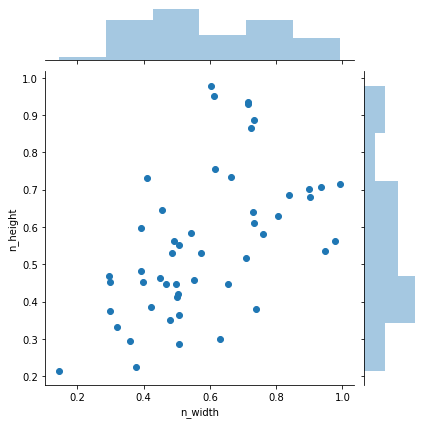

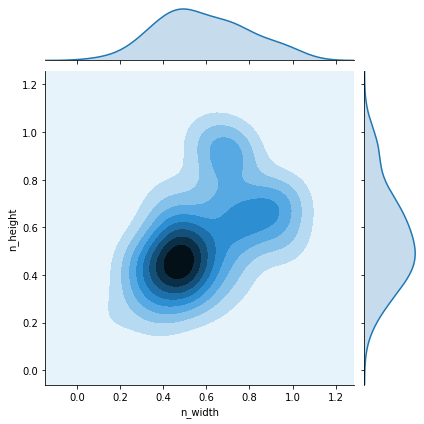

In [0]:
#Joint Plot of b_w and b_h
sns.jointplot(x="n_width", y="n_height", data=dataset)
sns.jointplot(x="n_width", y="n_height", data=dataset, kind='kde')

**The density graph of log of bounding box normalized width and height give a better demarkation of clusters as compared to normalized ones. Here, we can see a clear 2 cluster zone.**

Lets go deeper.

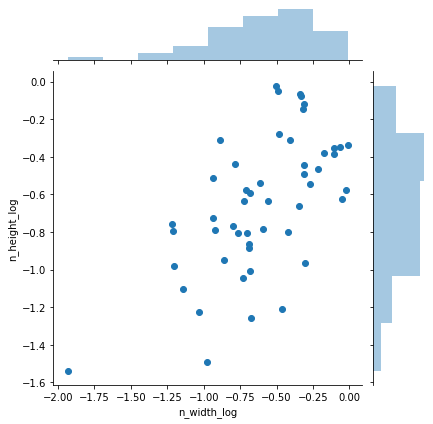

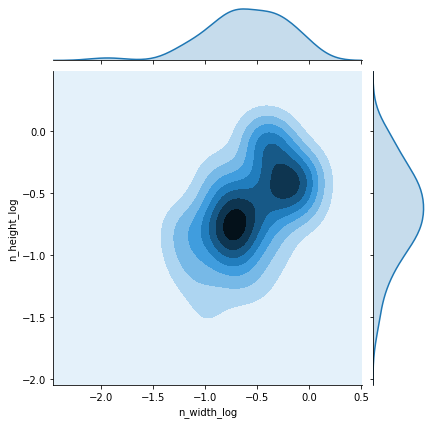

In [0]:
sns.jointplot(x="n_width_log", y="n_height_log", data=dataset)
sns.jointplot(x="n_width_log", y="n_height_log", data=dataset, kind='kde')

## Finding Best Clusters
---

**From the dataset, I selected normalized height and width of bounding boxes as *X* along with their normalized ones as *X1*. These values will be used by K-means clustering for finding out the clusters.**

In [0]:
# importing dataset
X = dataset.loc[:,['n_width', 'n_height']].values
X1 = dataset.loc[:,['n_width_log', 'n_height_log']].values

### Finding optimal "K"
---

1) K-means clustering was run with 25 consecutive values starting from 1.

2) For each value, the clusters found were used to calculate the average of max IoU of cluster centroid with respect to the corresponding normalized log and non-log bounding box dimension.

3) **wcss** contains the all the mean IoU for normalized bounding box dimension.

4) **wcss1** contains the all the mean IoU for log of normalized bounding box dimension.

In [0]:
num_iter = 25
wcss = iterate_kmeans(num_iter, X, X)
wcss1 = iterate_kmeans(num_iter, X1, X)

### Plotting mean IoU against number of clusters
---

For normalized bounding box dimension **wcss**, we see diminishing increase after 5th or 6th point.

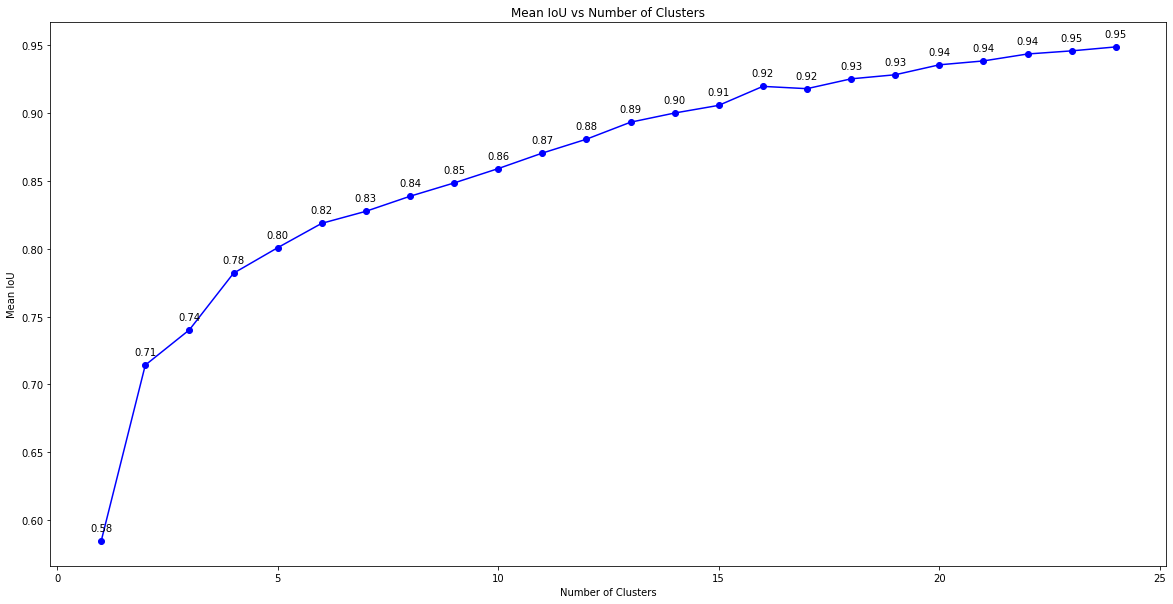

In [0]:
# Create plot
xs, ys = range(1,num_iter), wcss
visualize(xs, ys)

For log of normalized bounding box dimension **wcss1**, we see diminishing increase after 6th point. 

In this graph, there is marked increase in mean IoU after 5th point.

This solidifies the inference of using **6 number of clusters**.

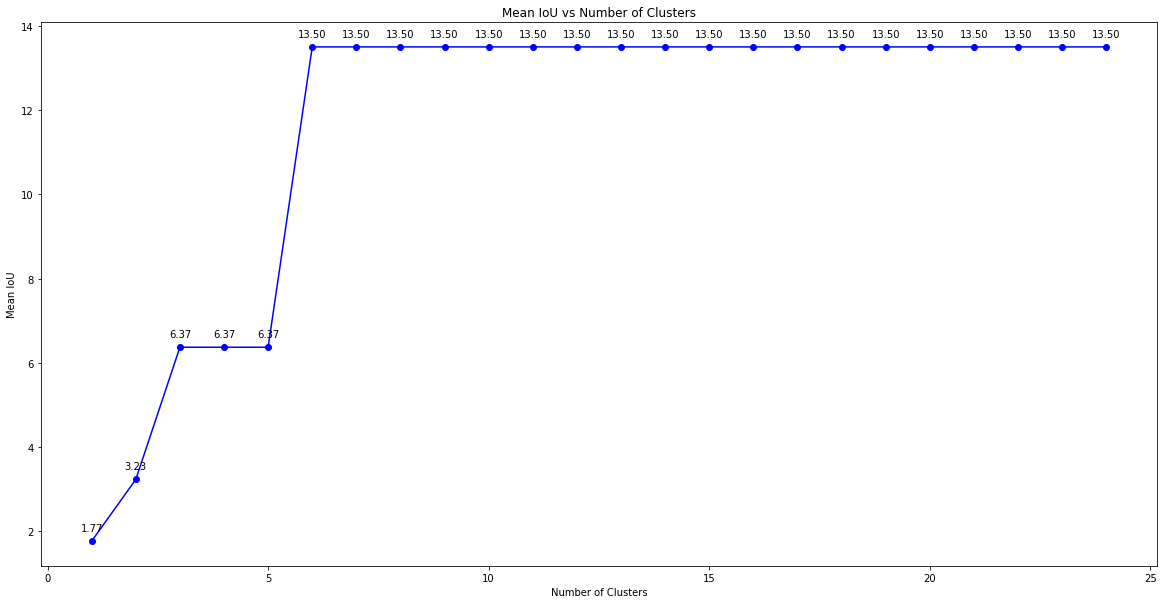

In [0]:
# Create plot
xs, ys = range(1,num_iter), wcss1
visualize(xs, ys)

### Finding clusters with K=6
---

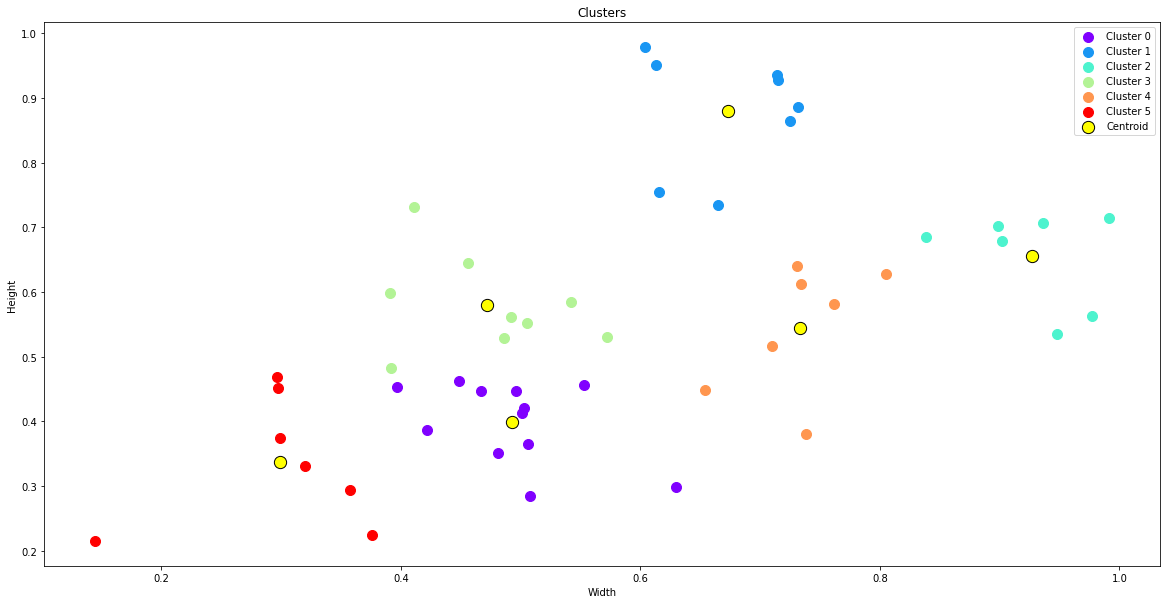

In [0]:
n_clusters=6
y_means, centroids = create_clusters(X, n_clusters)
plot_clusters(X, y_means, centroids, n_clusters)

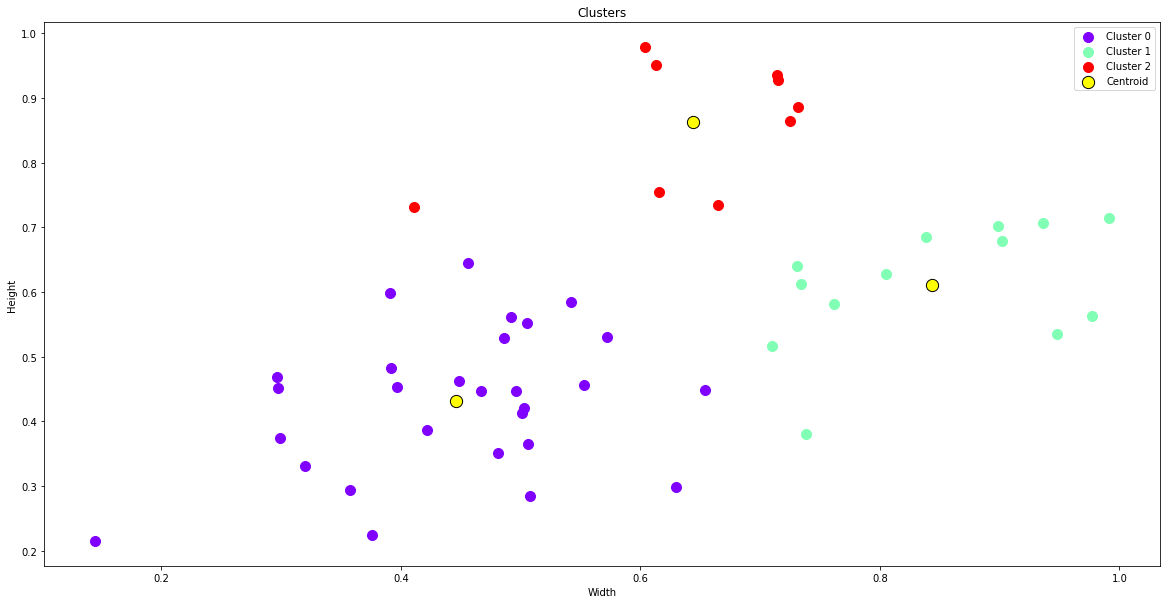

In [0]:
n_clusters=3
y_means, centroids = create_clusters(X, n_clusters)
plot_clusters(X, y_means, centroids, n_clusters)

### From the mean IoU vs number of clusters graphs, we can observe that **K=6 is the best number of cluster for this dog dataset which gives mean IoU of 0.82**